## LeafSnap Data Analysis using KNN

In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


2025-04-30 19:49:29.687664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocessing

### Cleaning the dataset
``` is_mostly_black(filepath, threshold, black_ratio) ```  
-  This takes a file, resizes it, looks at the number of "black" pixels (based on threshold param), calculates the ratio of black pixel, and returns a bool if the image is "mostly" black (based on black_ration param)

``` clean_dataset(dataframe) ```
- This function takes a dataframe (with pretty loading bar :D) it looks through the provied filepaths in the dataframe, calling ```is_mostly_black()``` on them and counting the ones that are mostly black.

In [72]:
def is_mostly_black(file_path, threshold=15, black_ratio=0.95):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, (512, 512))
        img_np = img.numpy()
        black_pixels = np.sum(img_np < threshold)
        total_pixels = img_np.size
        ratio = black_pixels / total_pixels
        return ratio >= black_ratio
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return False

def clean_dataset(df):
    species_black_counts = {}

    print("Checking images for mostly black...")
    for species in tqdm(df['species'].unique()):
        species_df = df[df['species'] == species]
        black_count = 0

        for path in species_df['segmented_path']:
            if is_mostly_black(path):
                black_count += 1

        total = len(species_df)
        black_ratio = black_count / total

        if black_ratio > 0.7:
            species_black_counts[species] = black_ratio

    species_to_remove = list(species_black_counts.keys())
    df_cleaned = df[~df['species'].isin(species_to_remove)].reset_index(drop=True)

    print(f"\nOriginal species: {df['species'].nunique()}")
    print(f"Remaining species after cleaning: {df_cleaned['species'].nunique()}")
    print(f"Remaining images: {len(df_cleaned)}")

    return df_cleaned


## Simple KNN

In [ ]:
raw_data = pd.read_csv('leafsnap-dataset-images.txt', sep='\t')
df = clean_dataset(raw_data)

species_counts = df['species'].value_counts()
print(species_counts)
species_to_keep = species_counts[species_counts >= 250].index
df = df[df['species'].isin(species_to_keep)].reset_index(drop=True)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['species'])

IMG_SIZE = (512, 512)

def extract_features(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    img = tf.image.rgb_to_grayscale(img)
    feature_vector = tf.reshape(img, [-1]) 
    return feature_vector.numpy()

features = []
labels = []

for path, label in zip(df['segmented_path'], encoded_labels):
    try:
        feature = extract_features(path)
        features.append(feature)
        labels.append(label)
    except Exception as e:
        print(f"Error processing {path}: {e}")

features = np.array(features)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)


print(f"Species to keep: {species_to_keep.size}")
print(f"Feature shape: {features.shape}")


Checking images for mostly black...


100%|██████████| 185/185 [01:00<00:00,  3.07it/s]



Original species: 185
Remaining species after cleaning: 107
Remaining images: 17967
species
Ulmus rubra                 317
Prunus virginiana           303
Acer rubrum                 297
Broussonettia papyrifera    294
Prunus sargentii            288
                           ... 
Styrax obassia               79
Quercus rubra                71
Toona sinensis               64
Quercus falcata              60
Magnolia soulangiana         56
Name: count, Length: 107, dtype: int64
Species to keep: 7
Feature shape: (2034, 262144)


### Train

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

### Evaluate & Visualize

KNN Test Accuracy (Top-1): 0.6560
KNN Test Accuracy (Top-5): 0.9459


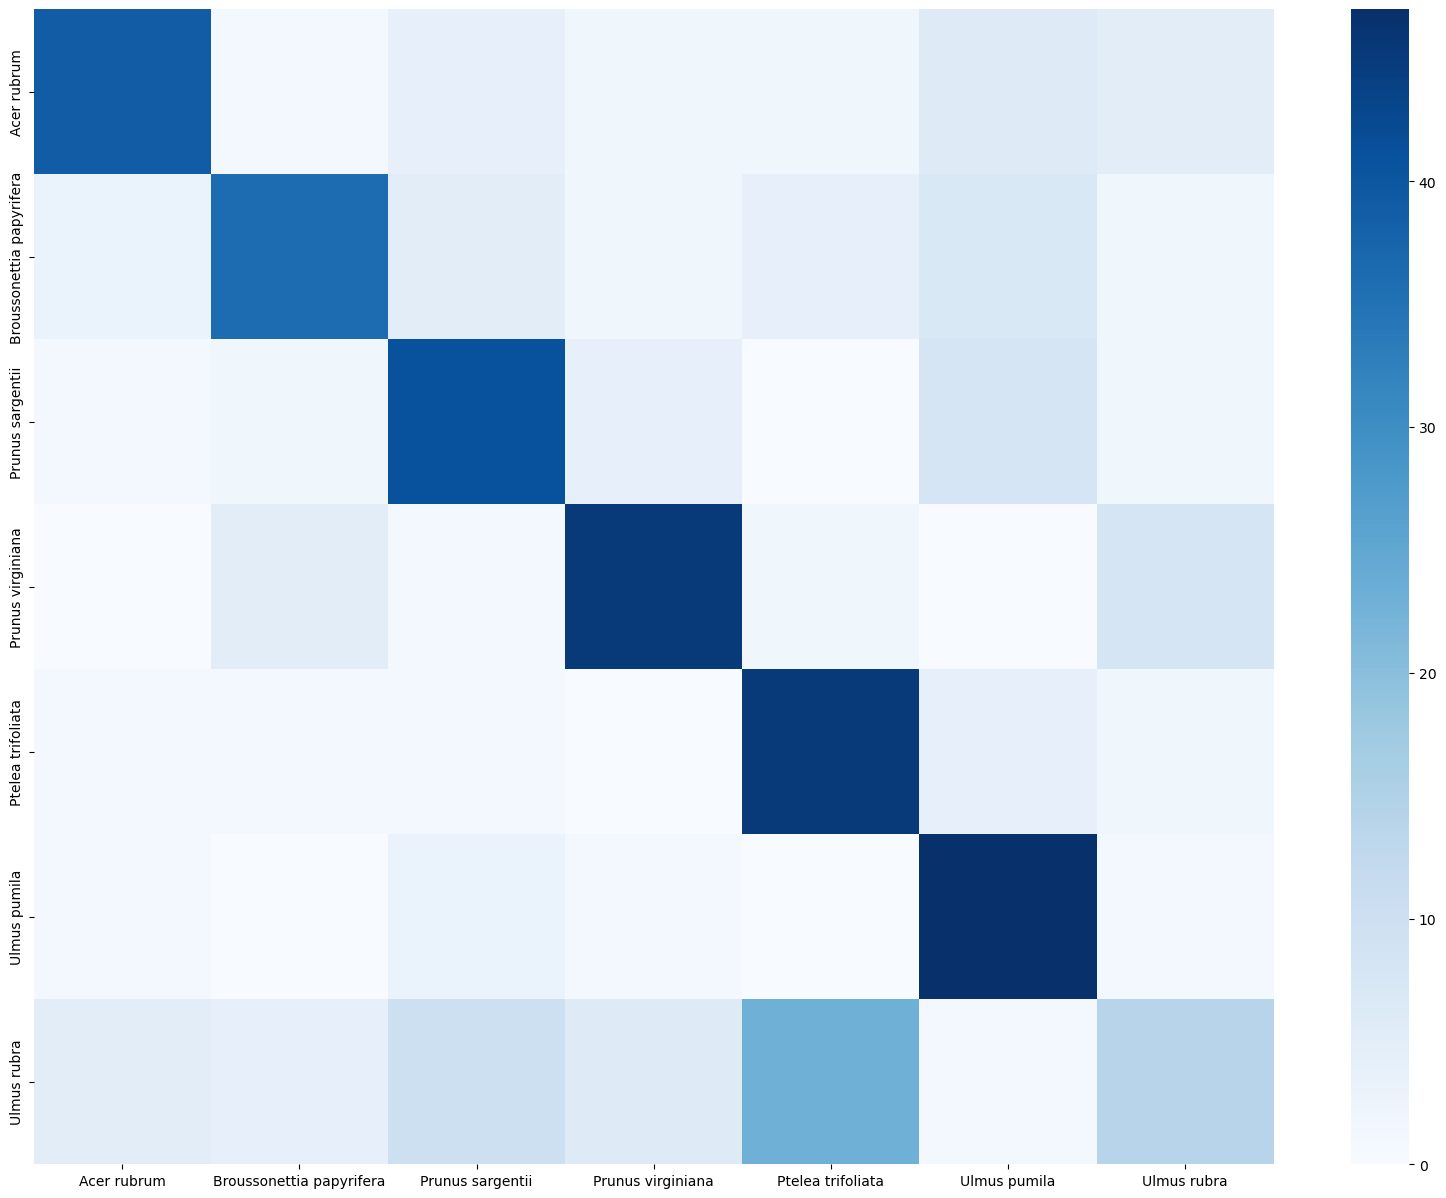

In [75]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.inverse_transform(range(len(species_to_keep))),
                     columns=label_encoder.inverse_transform(range(len(species_to_keep))))
plt.figure(figsize=(20, 15))
sns.heatmap(cm_df, annot=False, fmt='d', cmap='Blues')

acc = accuracy_score(y_test, y_pred)
top5_acc = top_k_accuracy_score(y_test, knn.predict_proba(X_test), k=5)
print(f"KNN Test Accuracy (Top-1): {acc:.4f}")
print(f"KNN Test Accuracy (Top-5): {top5_acc:.4f}")


## Fancy KNN
- Leaf Contour 
- Hu Moments
- PCA Dimentionality Reduction 

In [76]:

IMG_SIZE = (512, 512)

def extract_features(file_path, bins=30):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.rgb_to_grayscale(img)
    img_np = img.numpy()
    img_np = (img_np * 255).astype(np.uint8)

    contours, _ = cv2.findContours(img_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros(bins + 7)

    largest_contour = max(contours, key=cv2.contourArea)
    largest_contour = largest_contour.squeeze()

    if largest_contour.ndim != 2 or largest_contour.shape[0] < 5:
        return np.zeros(bins + 7)

    dx = np.gradient(largest_contour[:, 0])
    dy = np.gradient(largest_contour[:, 1])
    angles = np.arctan2(dy, dx)
    curvature = np.gradient(angles)
    hist, _ = np.histogram(curvature, bins=bins, range=(-np.pi, np.pi), density=True)

    hu = cv2.HuMoments(cv2.moments(largest_contour)).flatten()

    full_feature = np.concatenate([hist, hu])
    return full_feature

features = []
labels = []

for path, label in zip(df['segmented_path'], encoded_labels):
    try:
        feature = extract_features(path)
        features.append(feature)
        labels.append(label)
    except Exception as e:
        print(f"Error processing {path}: {e}")

features = np.array(features)
labels = np.array(labels)

print(f"Feature shape before PCA: {features.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = min(X_train_scaled.shape[0], X_train_scaled.shape[1], 50)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Feature shape after PCA: {X_train_pca.shape}")

knn = KNeighborsClassifier(n_neighbors=5, metric='cosine', weights='distance')
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
top5_acc = top_k_accuracy_score(y_test, knn.predict_proba(X_test_pca), k=5)

print(f"KNN Test Accuracy (Top-1): {acc:.4f}")
print(f"KNN Test Accuracy (Top-5): {top5_acc:.4f}")


Feature shape before PCA: (2034, 37)
Feature shape after PCA: (1627, 37)
KNN Test Accuracy (Top-1): 0.6339
KNN Test Accuracy (Top-5): 0.9214


### Evaluate and Visualize

KNN Test Accuracy (Top-1): 0.6339
KNN Test Accuracy (Top-5): 0.7076


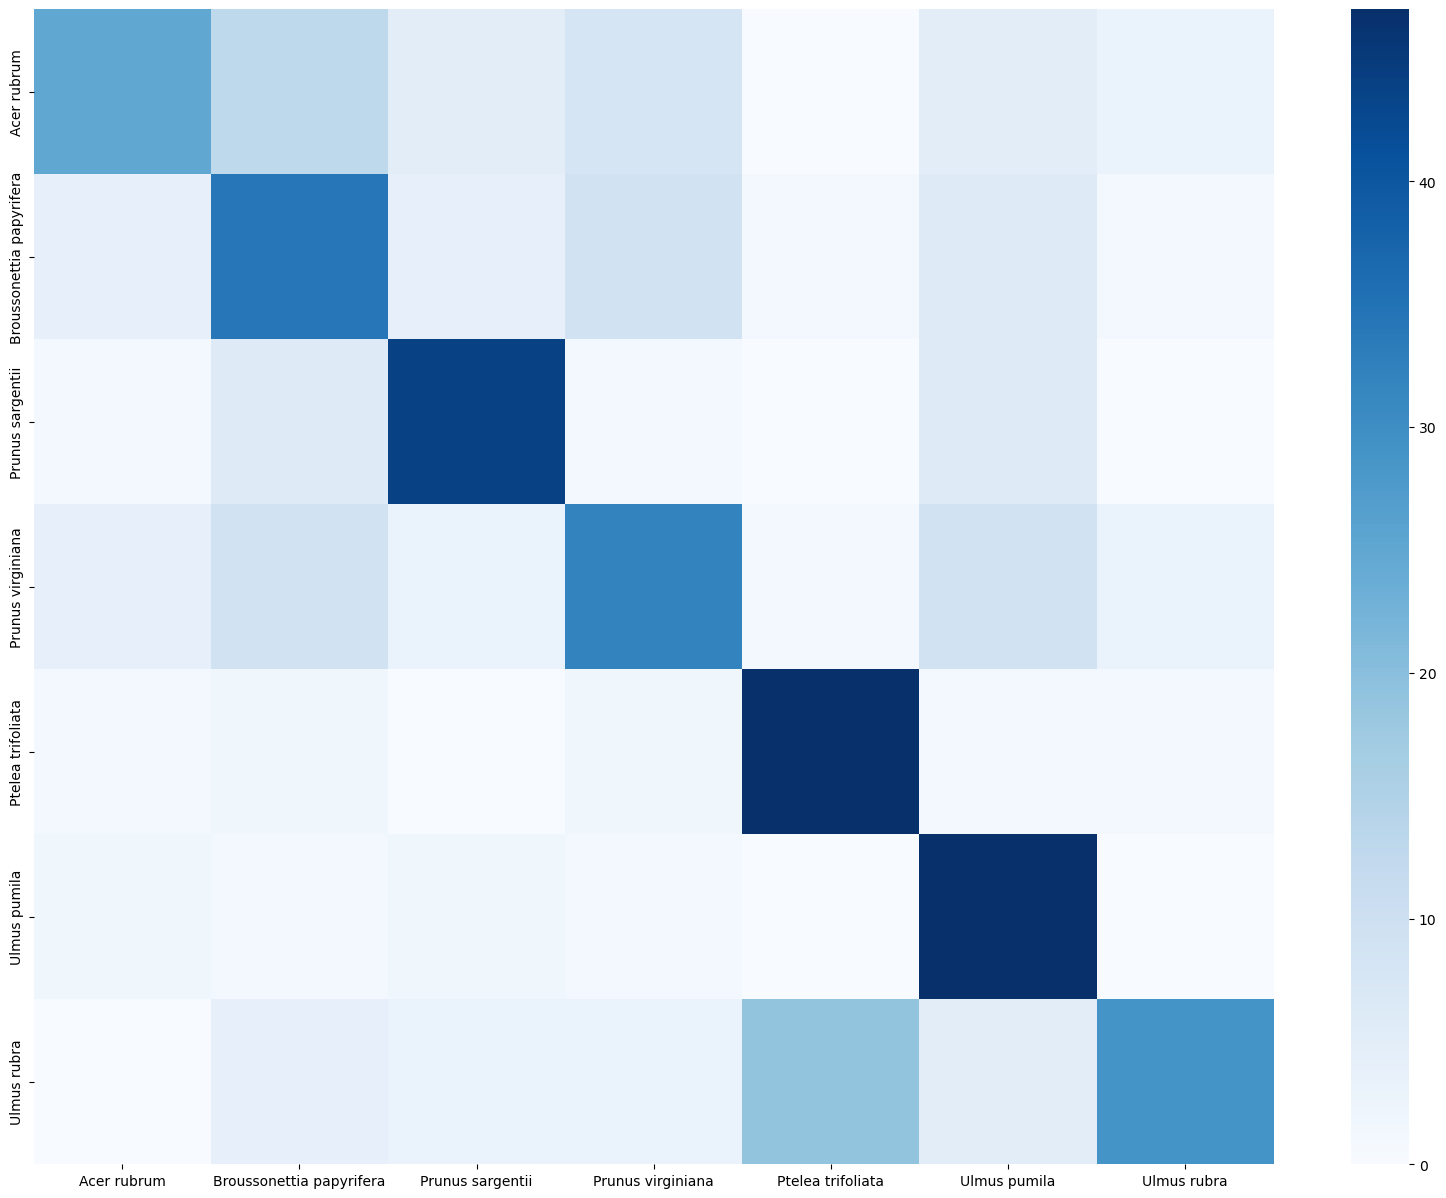

In [77]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.inverse_transform(range(len(species_to_keep))),
                     columns=label_encoder.inverse_transform(range(len(species_to_keep))))
plt.figure(figsize=(20, 15))
sns.heatmap(cm_df, annot=False, fmt='d', cmap='Blues')

acc = accuracy_score(y_test, y_pred)
top5_acc = top_k_accuracy_score(y_test, knn.predict_proba(X_test), k=5)
print(f"KNN Test Accuracy (Top-1): {acc:.4f}")
print(f"KNN Test Accuracy (Top-5): {top5_acc:.4f}")
